In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

C:\Users\surbhi.rathore\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


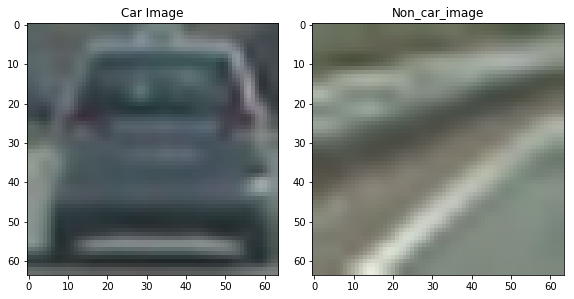

In [2]:
#reading Car And Not_Car images

image = mpimg.imread('vehicles/vehicles/GTI_Far/image0003.png')
notcar=mpimg.imread('non-vehicles/non-vehicles/GTI/image6.png')

plt.rcParams['figure.figsize'] = (12,7)
fig = plt.figure()
plt.subplot(131)
plt.imshow(image)
plt.title('Car Image')
plt.subplot(132)
plt.imshow(notcar)
plt.title('Non_car_image')
fig.tight_layout()

In [3]:
image1 = mpimg.imread('test_images/test1.jpg')

In [4]:
# Load image paths
vehicle_paths = ('./vehicles/vehicles/GTI*/*.png')
non_vehicle_paths = ('./non-vehicles/non-vehicles/GTI*/*.png')

cars = glob.glob(vehicle_paths)
non_cars = glob.glob(non_vehicle_paths)

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)   
        """if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            feature_image_hog = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image_hog, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)"""
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

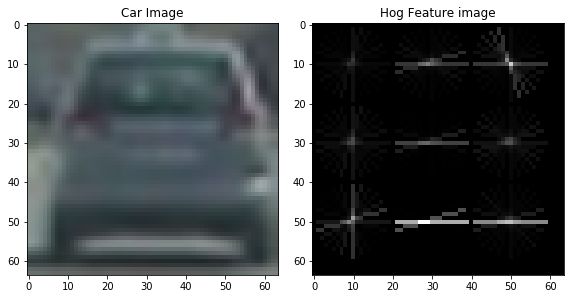

In [6]:
feat,img1=get_hog_features(image[:,:,0], 12, 20, 2, vis=True, feature_vec=True)

fig = plt.figure()
plt.subplot(131)
plt.imshow(image)
plt.title('Car Image')
plt.subplot(132)
plt.imshow(img1, cmap="gray")
plt.title('Hog Feature image')
fig.tight_layout()

In [7]:

car_features=extract_features(cars, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=12, 
                        pix_per_cell=20, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)


In [8]:
#Feature Extraction of Not_Car images
notcar_features=extract_features(non_cars, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=12, 
                        pix_per_cell=20, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

In [9]:
#DataSet Size
print("Total no of car images",len(car_features))
print("Total no of Not car images", len(notcar_features))
print("Feature vector size for each image",len(car_features[0]))

Total no of car images 8792
Total no of Not car images 8969
Feature vector size for each image 1056


#### Feature Vector:
  Feature Vector Normalization and split data set into training and test data

In [10]:
from sklearn.preprocessing import StandardScaler
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


#### Training Classifier 
Trained the classifier using "rbf" kernal

In [11]:
from sklearn.svm import LinearSVC,SVC
import time
svc = SVC(kernel="rbf")
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

print('My SVC predicts: ', svc.predict(X_test))
print('For these', 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict labels with SVC')

40.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [1. 1. 0. ... 0. 0. 0.]
For these labels:  [1. 1. 0. ... 0. 0. 0.]
9.13075 Seconds to predict labels with SVC


In [12]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [13]:
def slide_window(img, x_start_stop=[0, 1280], y_start_stop=[350, 720], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


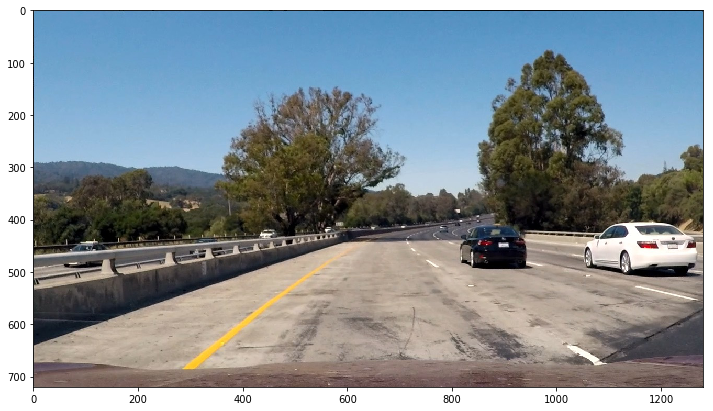

In [14]:
def search_windows(img, windows, clf, scaler, color_space='HLS', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        feat = []
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (96, 96))      
        #4) Extract features for that window using single_img_features()
        res= cv2.resize(test_img,(64,64), interpolation = cv2.INTER_CUBIC)
        features = single_img_features(res, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        feat.append(features)
        test_features = scaler.transform(feat)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

image = mpimg.imread('./test_images/test1.jpg')


plt.imshow(image)

In [15]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        height=bbox[1][1]-bbox[0][1]
        width=bbox[1][0]-bbox[0][0]
        
        if(height>64 and width>64):
            
            if(bbox[0][0]<850 and bbox[1][1]>600 ):
                continue
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



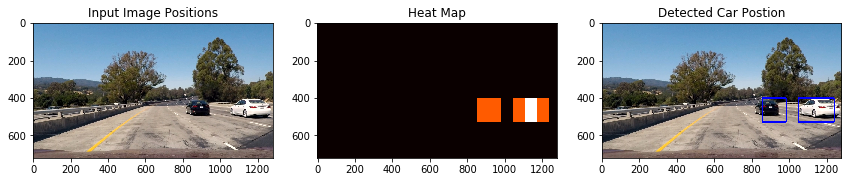

In [16]:
import pickle
from scipy.ndimage.measurements import label

win_size=[(64,64),(96,96),(128,128)]


heat = np.zeros_like(image[:,:,0]).astype(np.float)
window=[]
all_windows=[]
for win in range(len(win_size)):
    windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700], 
                    xy_window=win_size[win], xy_overlap=(0.50, 0.50))
    #all_windows.extend(windows)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YCrCb', spatial_size=(16, 16), 
                             hist_bins=32, orient=12, pix_per_cell=20, cell_per_block=2,  hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True)                       

    window += hot_windows





heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


plt.rcParams['figure.figsize'] = (12,7)
fig = plt.figure()
plt.subplot(131)
plt.imshow(image)
plt.title('Input Image Positions')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(draw_img)
plt.title('Detected Car Postion')
fig.tight_layout()





In [17]:
class History_Heatmap():
    def __init__(self):
        self.history=[]

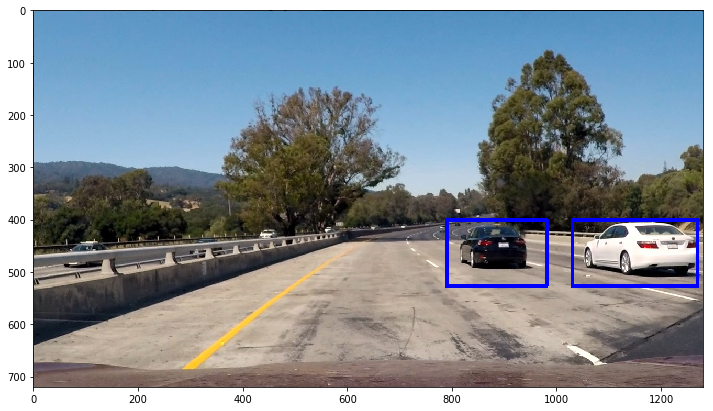

In [18]:
import functools as ft

win_size=[(64,64),(96,96),(128,128)]
previous_frames = 3
history = History_Heatmap()
    
def pipeline(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    window=[]
    all_windows=[]
    for win in range(len(win_size)):
        windows = slide_window(image, x_start_stop=[650, 1280], y_start_stop=[400, 700], 
                        xy_window=win_size[win], xy_overlap=(0.50, 0.50))
        
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YCrCb', spatial_size=(16, 16), 
                                 hist_bins=32, orient=12, pix_per_cell=20, cell_per_block=2,  hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True)                       
     
        window += hot_windows
        
                

   
    # Add heat to each box in box list
    heat = add_heat(heat,window)
    
    #taking average of last 4 boxes
    if len (history.history) > previous_frames:
        history.history = history.history[1:]
    history.history.append(heat)
    heat_history = ft.reduce(lambda h, acc: h + acc, history.history)/previous_frames
    


    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
 
    window=0

    return draw_img       


plt.imshow(pipeline(image))        
        

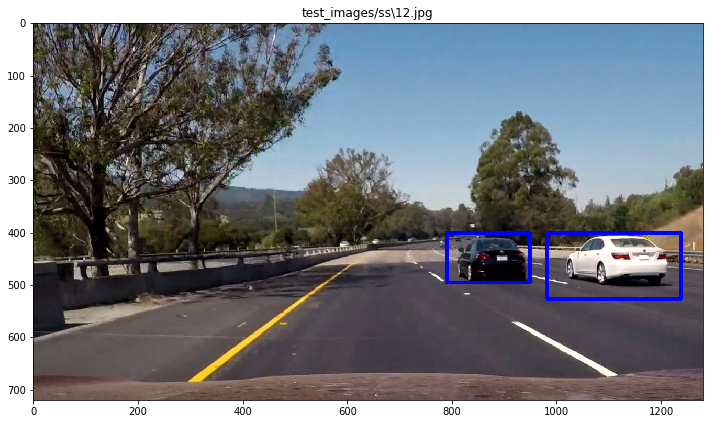

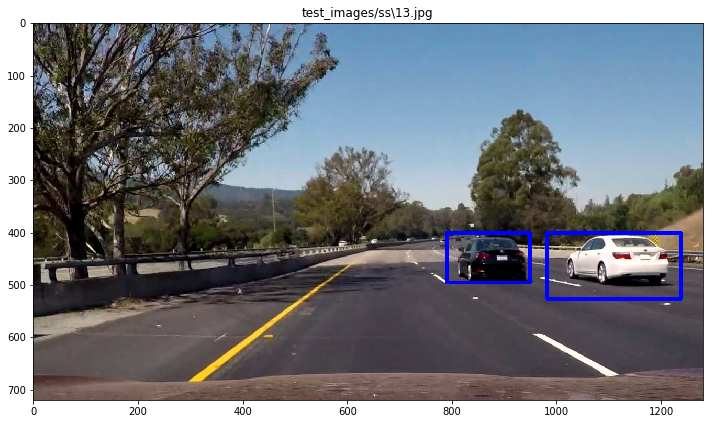

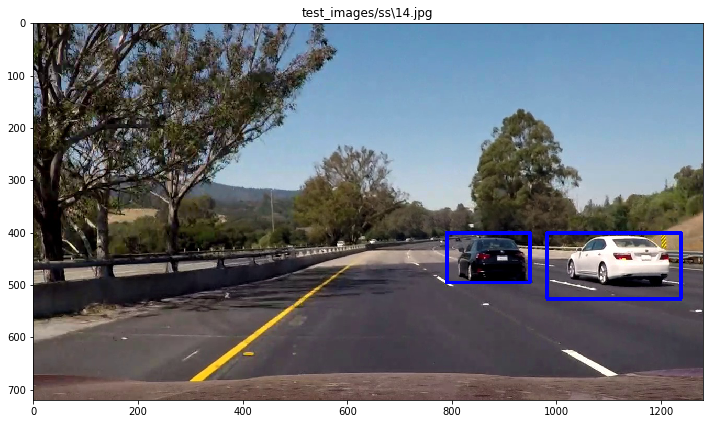

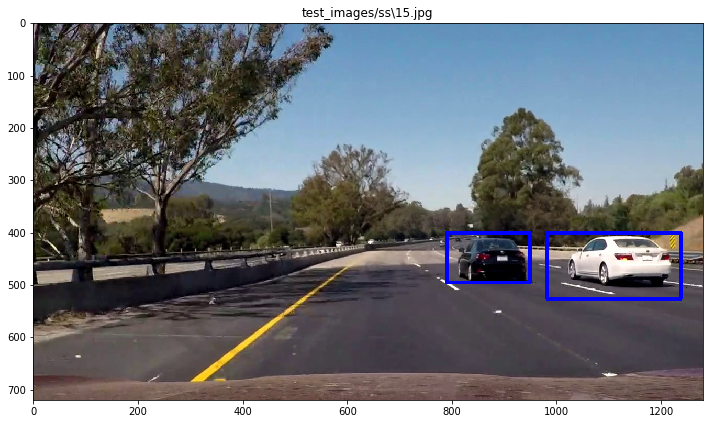

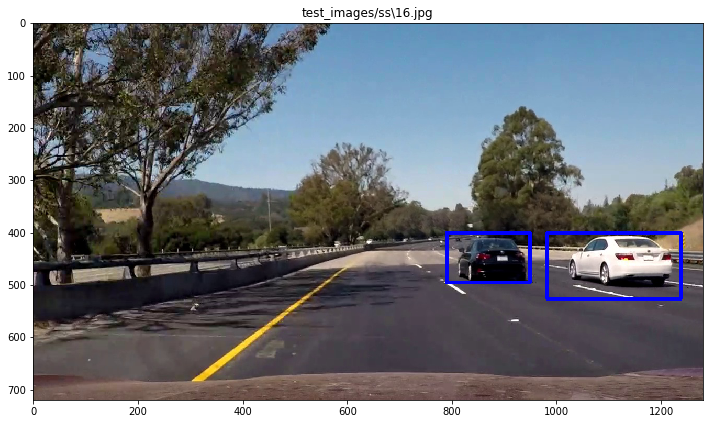

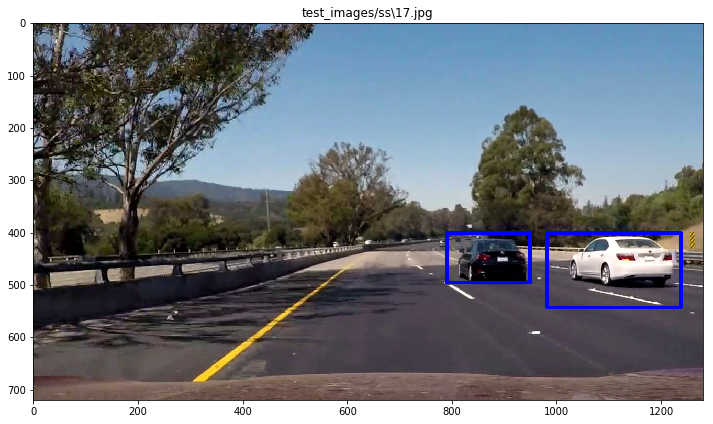

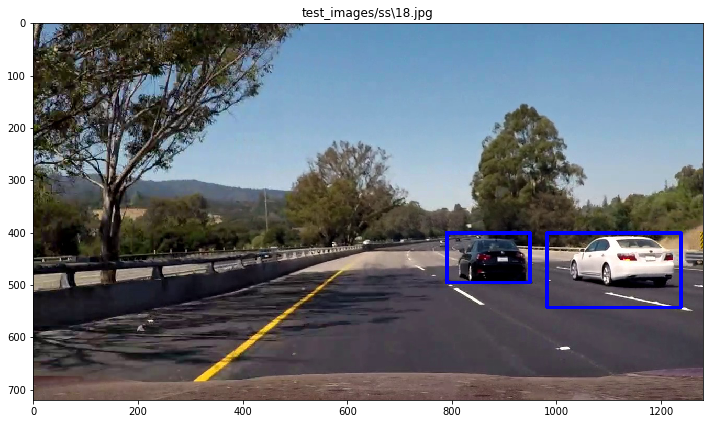

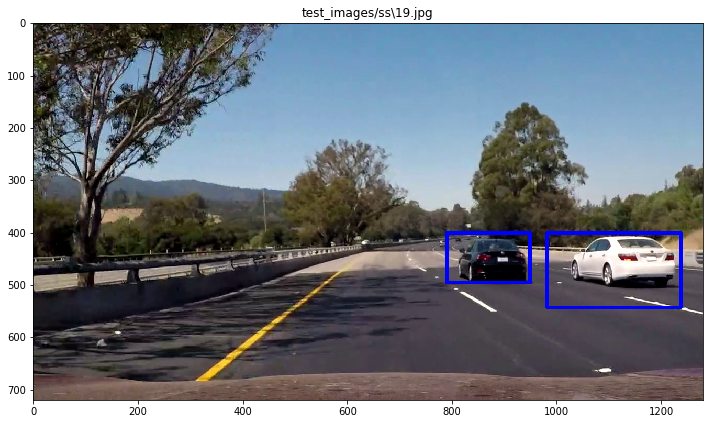

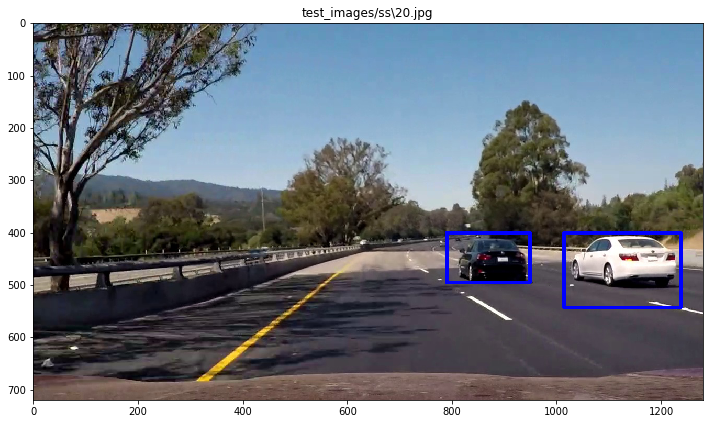

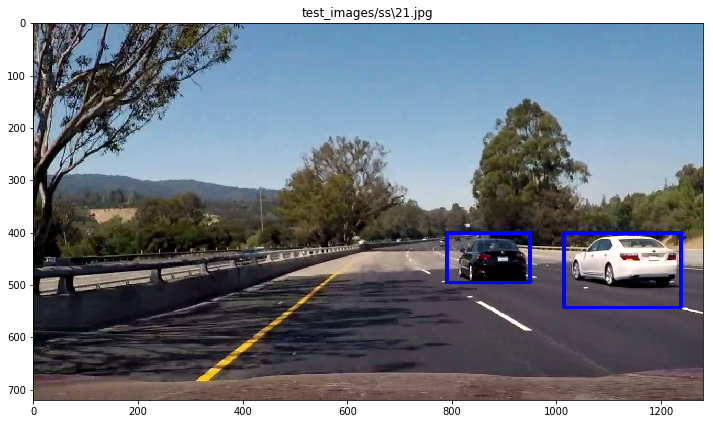

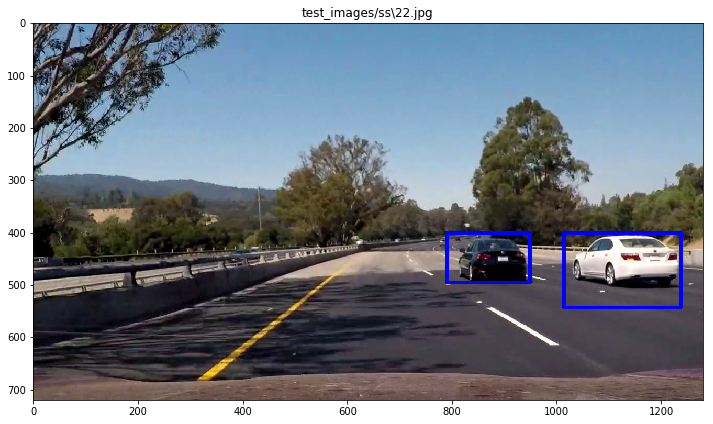

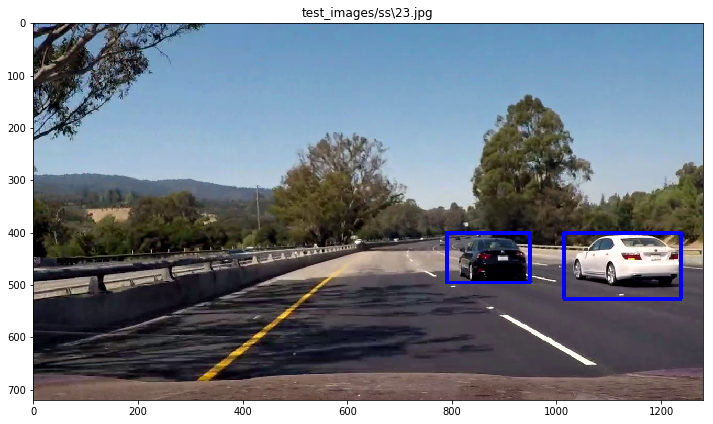

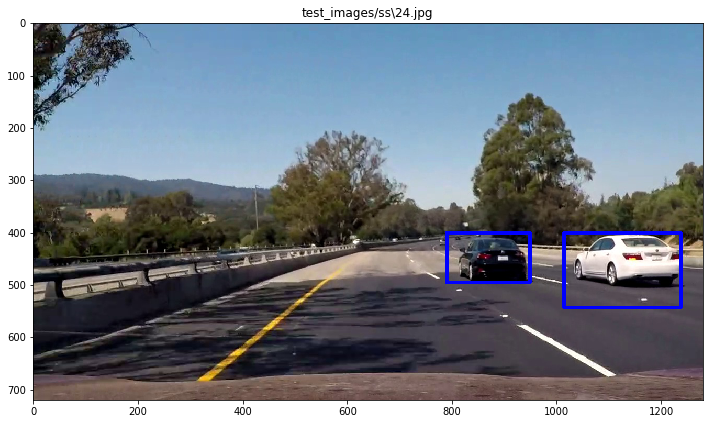

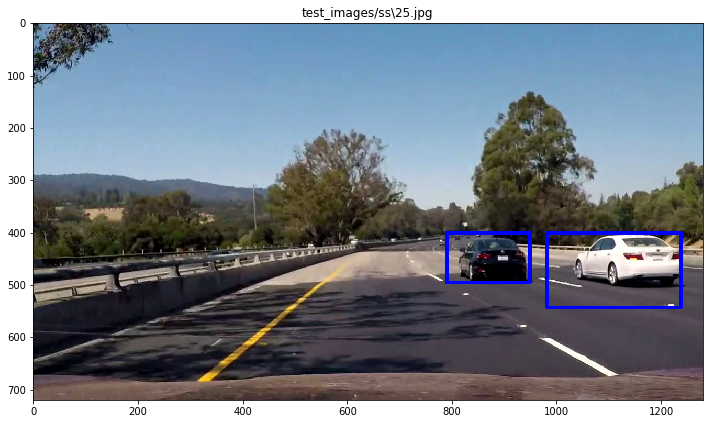

In [19]:
#Pipeline implementation on tets images
im=[]
im_path="test_images/ss/*.jpg"
test_images = glob.glob(im_path)

for img in test_images:
    plt.figure(img)
    plt.imshow(pipeline(plt.imread(img)))
    plt.title(img)

### Test Video

In [20]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'tets_vid.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(pipeline)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video tets_vid.mp4
[MoviePy] Writing video tets_vid.mp4


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 38/39 [00:34<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tets_vid.mp4 

Wall time: 36.7 s


In [21]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

### Project Video

In [22]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output1 = 'project_vid.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(pipeline)
%time video_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video project_vid.mp4
[MoviePy] Writing video project_vid.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:08<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_vid.mp4 

Wall time: 19min 10s


In [23]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output1))